In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])
     

sk


In [3]:
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI

# LLM 모델 설정
llm = ChatOpenAI(model="gpt-3.5-turbo")

# 첫 번째 AI 에이전트: 질문 분석 및 배경 정보 생성
def agent_1(state):
    """사용자의 질문을 분석하고 핵심 키워드와 배경 정보를 추가"""
    query = state["query"]
    
    # 질문에서 핵심 키워드 추출
    keywords = llm.invoke(f"질문: {query}\n이 질문에서 핵심 키워드를 3~5개 추출해 주세요.")
    
    # 질문과 관련된 배경 정보 제공
    background_info = llm.invoke(f"질문: {query}\n이 질문을 이해하는 데 도움이 될 만한 추가 정보를 제공해 주세요.")

    print(f"\n[Agent 1] 원본 질문: {query}")
    print(f"[Agent 1] 핵심 키워드: {keywords}")
    print(f"[Agent 1] 배경 정보: {background_info}\n")

    return {"refined_query": query, "keywords": keywords, "background_info": background_info}

# 두 번째 AI 에이전트: 키워드 및 배경 정보를 활용하여 답변 생성
def agent_2(state):
    """Agent 1이 제공한 정보를 기반으로 보다 정교한 답변 생성"""
    refined_query = state["refined_query"]
    keywords = state["keywords"]
    background_info = state["background_info"]

    # Agent 1이 제공한 정보를 활용하여 최종 답변 생성
    final_response = llm.invoke(
        f"질문: {refined_query}\n"
        f"핵심 키워드: {keywords}\n"
        f"배경 정보: {background_info}\n"
        f"위 정보를 바탕으로 질문에 대해 깊이 있는 답변을 작성해 주세요."
    )

    print(f"[Agent 2] 최종 답변 생성 완료\n")
    
    return {"final_answer": final_response}

# LangGraph Workflow 설정
workflow = StateGraph(dict)  

# 그래프의 시작점 정의
workflow.add_node("agent_1", agent_1)
workflow.add_node("agent_2", agent_2)

# 실행 흐름(Edges) 정의
workflow.set_entry_point("agent_1")  # Agent 1이 먼저 실행됨
workflow.add_edge("agent_1", "agent_2")  # Agent 1 -> Agent 2

# 실행 엔진 빌드
app = workflow.compile()
print(type(app))

# 실행 예제
query = "LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?"
state = {"query": query}
result = app.invoke(state)

# 최종 결과 출력
print("\n🔹 [AI 최종 답변]:")
print(result["final_answer"])



<class 'langgraph.graph.state.CompiledStateGraph'>

[Agent 1] 원본 질문: LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?
[Agent 1] 핵심 키워드: content='- LangGraph\n- LangChain\n- 차이점\n- 사용 이유' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 89, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BhtNaafcXSaQwecitvKuPRWhnhMIv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--dc17745c-3681-4fed-a721-f909dd7534e2-0' usage_metadata={'input_tokens': 89, 'output_tokens': 20, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
[Agent 1] 배경 정보: content='

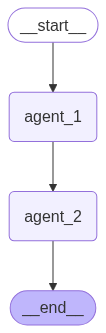

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)        
    )
)